# Dataset:
DREAMER, a multi-modal database consisting of electroencephalogram (EEG) and
electrocardiogram (ECG) signals recorded during affect elicitation by means of audio-visual stimuli.
Signals from 23 participants were recorded along with the participants’ self-assessment of their
affective state after each stimuli, in terms of valence, arousal, and dominance. All the signals were
captured using portable, wearable, wireless, low-cost and off-the-shelf equipment that has the
potential to allow the use of affective computing methods in everyday applications. The Emotiv EPOC
wireless EEG headset was used for EEG and the Shimmer2 ECG sensor for ECG.

## Dataset Description:
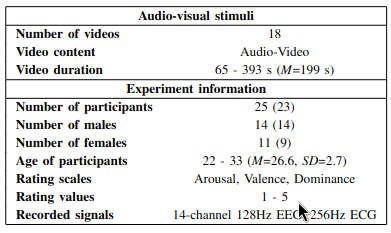
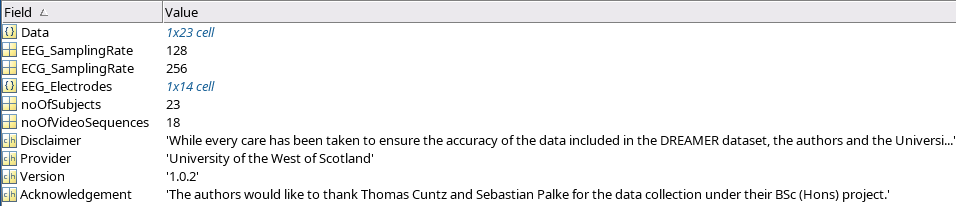

## Electroenchephalogram Signals:
The captured EEG signals were separated into the theta (4 Hz - 8 Hz), alpha (8 Hz - 13 Hz), and beta (13 Hz - 20 Hz) frequency bands. The logarithms of the PSD from each of the aforementioned bands are extracted from the signal of each of the 14 electrodes in order to be used as features
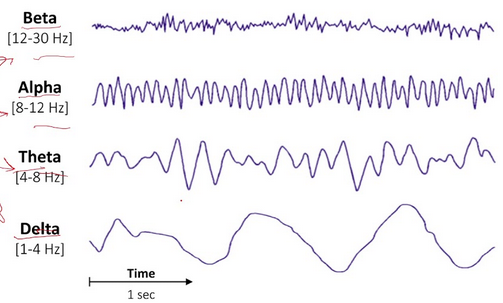


In [1]:
%%capture
!pip install ssqueezepy
!pip install timm
!pip install pytorch-lightning

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import re
import random
from PIL import Image

In [3]:
data = scipy.io.loadmat('/kaggle/input/dreamer/DREAMER.mat')

In [4]:
PATIENTS = 23
VIDEOS = 18

Features = {
    'Age' : 0,
    'Gender': 1,
    'EEG' : 2,
    'ECG' : 3,
    'Valence' : 4,
    'Arousal' : 5,
    'Dominance' : 6
}


signal_types = {
    'BaseLine' :0,
    'Stimulie' :1
}


def retrieve_data(Sample_index, Feature_name, Video_idx):
    """
    Retrieve specific feature data for a given patient from the dataset.

    Parameters:
        Sample_index (int): Index of the patient (0 to 23).
        Feature_name (str): Name of the feature to retrieve. It should be one of the following:
                            'Age', 'Gender', 'EEG', 'ECG', 'Valence', 'Arousal', 'Dominance'.

    Returns:
        float: The value of the specified feature for the specified patient.

    Raises:
        KeyError: If Feature_name is not one of the supported features.
    """
    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_name]][Video_idx]

def retrieve_signals(Sample_index, Feature_type, signal_type):
    """
    Retrieve specific signal data for a given patient from the dataset.

    Parameters:
        Sample_index (int): Index of the patient (0 to 23).
        Feature_type (str): Type of feature ('EEG' or 'ECG').
        signal_type (str): Type of signal to retrieve ('BaseLine' or 'Stimulie').

    Returns:
        float: The value of the specified signal for the specified patient.

    Raises:
        ValueError: If Feature_type is not 'EEG' or 'ECG'.
    """
    if Feature_type not in ('EEG', 'ECG'):
        raise ValueError(f"Invalid Feature_type: {Feature_type}. Feature_type must be 'EEG' or 'ECG'.")

    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_type]][0][0][signal_types[signal_type]]

In [5]:
ECG_Stimuli = []
ECG_Baseline = []
EEG_Baseline = []
EEG_Stimuli = []

for i in range(PATIENTS):
    baseline = retrieve_signals(i,'ECG','BaseLine')            
    ECG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'ECG','Stimulie')            
    ECG_Stimuli.append(stimuli)
    baseline = retrieve_signals(i,'EEG','BaseLine')       
    EEG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'EEG','Stimulie')             
    EEG_Stimuli.append(stimuli)

In [6]:
big_df = pd.DataFrame()
df = pd.DataFrame()
patients = []
for i in range(PATIENTS): # for i in every patient
    for j in range(VIDEOS): # for j in every Video
        patient_index = [i] * len(EEG_Stimuli[i][j][0])
        video_index = [j] * len(EEG_Stimuli[i][j][0])
        valence = [retrieve_data(i, 'Valence', j)[0]] * len(EEG_Stimuli[i][j][0])
        arousal = [retrieve_data(i, 'Arousal', j)[0]] * len(EEG_Stimuli[i][j][0])
        dominance = [retrieve_data(i, 'Dominance', j)[0]] * len(EEG_Stimuli[i][j][0])
        electrodes = []
        for k in range(14): # for k in every electrode
            electrode = []
            for l,row  in enumerate(EEG_Stimuli[i][j][0]):
                electrode.append(row[k])
            electrodes.append(electrode)   
        Dict = {
            'patient_index' : patient_index,
            'video_index' : video_index,
            'valence' : valence,
            'arousal' : arousal,
            'dominance' : dominance
        }
        columns_list = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        for idx , key in enumerate(columns_list):
            Dict[key] = electrodes[idx]
        df = pd.DataFrame(Dict)
        patients.append(df)
big_df = pd.concat(patients)

In [7]:
big_df.video_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [8]:
big_df.patient_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [9]:
big_df

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0,0,4,3,2,4388.205128,4102.564103,4219.487179,4465.128205,4370.769231,4399.487179,4443.076923,4023.076923,4365.128205,4310.256410,3953.846154,4454.358974,4326.153846,4165.128205
1,0,0,4,3,2,4375.897436,4093.846154,4252.820513,4522.564103,4435.897436,4411.794872,4488.717949,4108.717949,4399.487179,4384.615385,4007.692308,4466.666667,4372.820513,4247.179487
2,0,0,4,3,2,4378.461538,4091.282051,4230.256410,4488.205128,4370.256410,4402.564103,4461.025641,4077.435897,4378.461538,4328.717949,3986.153846,4461.025641,4328.205128,4203.589744
3,0,0,4,3,2,4393.846154,4101.025641,4193.333333,4418.974359,4270.256410,4392.307692,4411.282051,3982.564103,4336.410256,4213.333333,3930.256410,4442.564103,4261.025641,4100.000000
4,0,0,4,3,2,4396.410256,4108.717949,4210.769231,4436.410256,4310.769231,4401.025641,4426.666667,3980.512821,4349.743590,4238.461538,3945.128205,4446.666667,4289.743590,4115.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23803,22,17,2,4,2,4400.000000,4106.153846,4163.589744,4415.897436,4311.282051,4378.974359,4493.333333,3957.948718,4334.871795,4299.487179,3944.102564,4454.358974,4341.025641,4160.000000
23804,22,17,2,4,2,4371.794872,4100.512821,4164.102564,4406.153846,4311.282051,4381.538462,4490.256410,3941.538462,4311.794872,4278.974359,3920.000000,4430.769231,4310.256410,4145.128205
23805,22,17,2,4,2,4370.256410,4097.948718,4155.897436,4408.205128,4313.333333,4380.000000,4490.256410,3945.641026,4315.384615,4274.871795,3923.589744,4441.538462,4301.538462,4136.410256
23806,22,17,2,4,2,4373.846154,4087.692308,4158.461538,4409.230769,4312.307692,4376.410256,4489.743590,3950.256410,4321.538462,4275.384615,3921.538462,4432.307692,4295.384615,4142.051282


In [10]:
grouped_df = big_df.groupby(['patient_index', 'video_index']).mean().reset_index()

In [11]:
grouped_df

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0,0,4.0,3.0,2.0,4380.218460,4093.074125,4158.109156,4393.518655,4295.999831,4378.748389,4434.144984,3955.981490,4304.093384,4256.660365,3934.476872,4405.790209,4285.140506,4158.345393
1,0,1,3.0,3.0,1.0,4388.493529,4103.419670,4163.580232,4410.191818,4319.132627,4354.399467,4451.704682,3958.206382,4313.717490,4274.703495,3939.122596,4445.382077,4303.317185,4202.386353
2,0,2,5.0,4.0,4.0,4388.187917,4108.831372,4163.864447,4410.005238,4316.097204,4357.565806,4451.039710,3954.966982,4309.079988,4274.770472,3937.527193,4461.734188,4310.371169,4201.471780
3,0,3,4.0,3.0,2.0,4393.849871,4115.479442,4179.318814,4419.010489,4306.440208,4352.845686,4456.328101,3968.441096,4311.054386,4265.888072,3944.887121,4465.420770,4301.572757,4192.231160
4,0,4,4.0,4.0,4.0,4388.533271,4111.512184,4240.120192,4418.574248,4300.556155,4341.445607,4448.318987,3984.846549,4305.414811,4261.750890,3954.639747,4462.130350,4292.819099,4198.149333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,22,13,2.0,2.0,2.0,4384.971531,4104.184059,4167.153610,4420.616257,4317.316412,4369.968232,4492.272813,3937.622172,4316.522012,4278.015766,3930.405849,4522.457344,4299.459135,4183.513103
410,22,14,2.0,2.0,2.0,4382.067893,4103.736862,4162.004987,4415.487689,4316.218534,4366.856737,4439.508083,3935.958260,4315.734422,4276.555216,3930.494740,4510.667900,4302.228423,4186.060047
411,22,15,3.0,3.0,2.0,4362.806357,4092.465607,4148.741884,4406.947506,4305.184706,4365.029915,4459.969572,3923.326204,4298.418454,4263.581710,3915.684644,4455.840134,4289.359077,4175.677166
412,22,16,2.0,2.0,4.0,4381.298859,4106.109776,4165.188880,4406.204818,4310.076967,4375.107516,4442.527184,3937.405740,4314.517556,4277.634434,3925.473085,4455.151383,4304.197857,4178.936439


In [12]:
groups=big_df.groupby(['patient_index','video_index'])
grp_keys=list(groups.groups.keys())
print(grp_keys)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10)

In [13]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    #data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0.5)
    return epochs.get_data()


In [14]:
grpno=grp_keys[0]
grp1=groups.get_group(grpno).drop(['patient_index','video_index'],axis=1)
label_valence=grp1['valence']
label_arousal=grp1['arousal']
label_dominance=grp1['dominance']
patient_id=grpno[0]
grp1=grp1.drop(['valence','arousal','dominance'],axis=1)
grp1

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4388.205128,4102.564103,4219.487179,4465.128205,4370.769231,4399.487179,4443.076923,4023.076923,4365.128205,4310.256410,3953.846154,4454.358974,4326.153846,4165.128205
1,4375.897436,4093.846154,4252.820513,4522.564103,4435.897436,4411.794872,4488.717949,4108.717949,4399.487179,4384.615385,4007.692308,4466.666667,4372.820513,4247.179487
2,4378.461538,4091.282051,4230.256410,4488.205128,4370.256410,4402.564103,4461.025641,4077.435897,4378.461538,4328.717949,3986.153846,4461.025641,4328.205128,4203.589744
3,4393.846154,4101.025641,4193.333333,4418.974359,4270.256410,4392.307692,4411.282051,3982.564103,4336.410256,4213.333333,3930.256410,4442.564103,4261.025641,4100.000000
4,4396.410256,4108.717949,4210.769231,4436.410256,4310.769231,4401.025641,4426.666667,3980.512821,4349.743590,4238.461538,3945.128205,4446.666667,4289.743590,4115.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25467,4397.435897,4112.307692,4209.230769,4436.410256,4364.615385,4375.384615,4460.512821,4004.102564,4356.410256,4323.589744,3965.641026,4476.923077,4341.538462,4192.307692
25468,4387.179487,4104.102564,4218.461538,4451.794872,4389.743590,4382.051282,4475.897436,4023.589744,4367.179487,4348.205128,3971.794872,4472.307692,4354.358974,4192.307692
25469,4371.282051,4092.307692,4237.435897,4490.256410,4421.538462,4391.282051,4505.128205,4077.435897,4389.743590,4382.564103,3996.923077,4475.384615,4377.948718,4230.256410
25470,4371.794872,4089.743590,4214.358974,4466.666667,4391.794872,4377.948718,4478.461538,4049.230769,4365.641026,4348.717949,3973.333333,4466.153846,4351.794872,4206.666667


In [15]:
test=convertDF2MNE(grp1)
test.shape

Creating RawArray with float64 data, n_channels=14, n_times=25472
    Range : 0 ... 25471 =      0.000 ...   198.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 56 events and 512 original time points ...
0 bad epochs dropped


(56, 14, 512)

In [16]:
!mkdir scaleogram

In [17]:
Wx, scales = cwt(test[0], 'morlet')
Wx.shape

(14, 230, 512)

(14, 230, 512)
[[  0.62996566+0.00261904j  -0.6224363 +0.0694089j
    0.60064083-0.13716446j ...   0.5994873 +0.15340202j
   -0.6241205 -0.08046003j   0.63262606+0.00263377j]
 [  0.96539986+0.00362679j  -0.9521777 +0.1151952j
    0.91404694-0.22612754j ...   0.9184598 +0.25335744j
   -0.9617013 -0.13299057j   0.9766753 +0.00364702j]
 [  1.4090782 +0.00470799j  -1.3866364 +0.18358234j
    1.3222107 -0.35773066j ...   1.339091  +0.4018131j
   -1.4123074 -0.21125072j   1.4377452 +0.00473402j]
 ...
 [ -0.455989  -0.0243113j   -0.45558766-0.02937028j
   -0.45513403-0.03442278j ...  -0.6292094 +0.02552537j
   -0.6295733 +0.0172718j   -0.6298262 +0.00901269j]
 [ -4.281255  -0.09297085j  -4.2797914 -0.14549841j
   -4.2776833 -0.19800405j ...  -4.282751  +0.06486001j
   -4.283225  +0.01229613j  -4.283054  -0.04026958j]
 [-13.701783  -0.29728436j -13.6971035 -0.46540394j
  -13.690361  -0.63345337j ... -13.703441  +0.2072418j
  -13.704952  +0.03906396j -13.7044    -0.12911984j]] (230, 512)


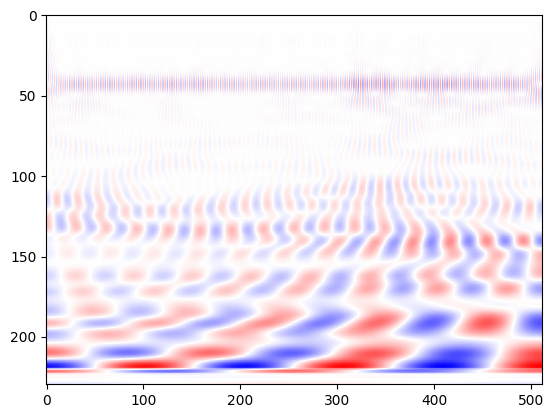

In [18]:
print(Wx.shape)
print(Wx[0], Wx[0].shape)
imshow(Wx[0])

In [19]:
%%capture
# Label = 'valence'
# images = []
grpnos,labels,paths=[],[],[]
for i,grpno in enumerate(grp_keys):
    grp=groups.get_group(grpno).drop(['patient_index','video_index'],axis=1)
    label=int(grp['valence'].unique())
    subject_id=grpno[0]
    grp=grp.drop(['valence','arousal','dominance'],axis=1)
    data=convertDF2MNE(grp)#(trials, channels, length)
    for c,x in enumerate(data):#loop trials
        if random.random() < 0.9:
            continue
        else:
            Wx, scales = cwt(x, 'morlet')
            Wx=np.abs(Wx)
            path=os.path.join('./scaleogram',f'subvideo_{grpno}/',)
            os.makedirs(path,exist_ok=True)
            path=path+f'trial_{c}.jpeg'
            im = Image.fromarray(Wx[0])
            im = im.convert("L")
            im.save(path)

    #                 images.append(Wx)
            grpnos.append(i)
            labels.append(label)
            paths.append(path)

In [20]:
df_scale=pd.DataFrame(zip(paths,labels,grpnos),columns=['path','label','group'])
df_scale.shape

(2581, 3)

In [21]:
df_scale['label'] = df_scale['label'].astype('string')

In [22]:
df_scale.dtypes

path             object
label    string[python]
group             int64
dtype: object

In [23]:
df_scale.label.unique()

<StringArray>
['4', '3', '5', '1', '2']
Length: 5, dtype: string

In [24]:
df_scale.to_csv('dataset_&_labels.csv', index=False, header=True) 

In [25]:
# print(len(images),len(labels))
# imshow(images[205], "Label: "+str(labels[205]))

In [26]:
from sklearn.model_selection import train_test_split
from keras.src.legacy.preprocessing.image import ImageDataGenerator
train_df, test_df = train_test_split(df_scale.drop('group', axis=1), test_size=0.2, random_state=43)

2024-05-06 17:53:27.813430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 17:53:27.813559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 17:53:27.946428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_gen = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                x_col="path",
                                                y_col="label",
                                                target_size=(255, 255),
                                                batch_size=32,
                                                class_mode="categorical")

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                              x_col="path",
                                              y_col="label",
                                              target_size=(255, 255),
                                              batch_size=32,
                                              class_mode="categorical")

Found 2064 validated image filenames belonging to 5 classes.
Found 517 validated image filenames belonging to 5 classes.


In [28]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,001,029 (240.33 MB)

 Trainable params: 63,001,029 (240.33 MB)

 Non-trainable params: 0 (0.00 B)

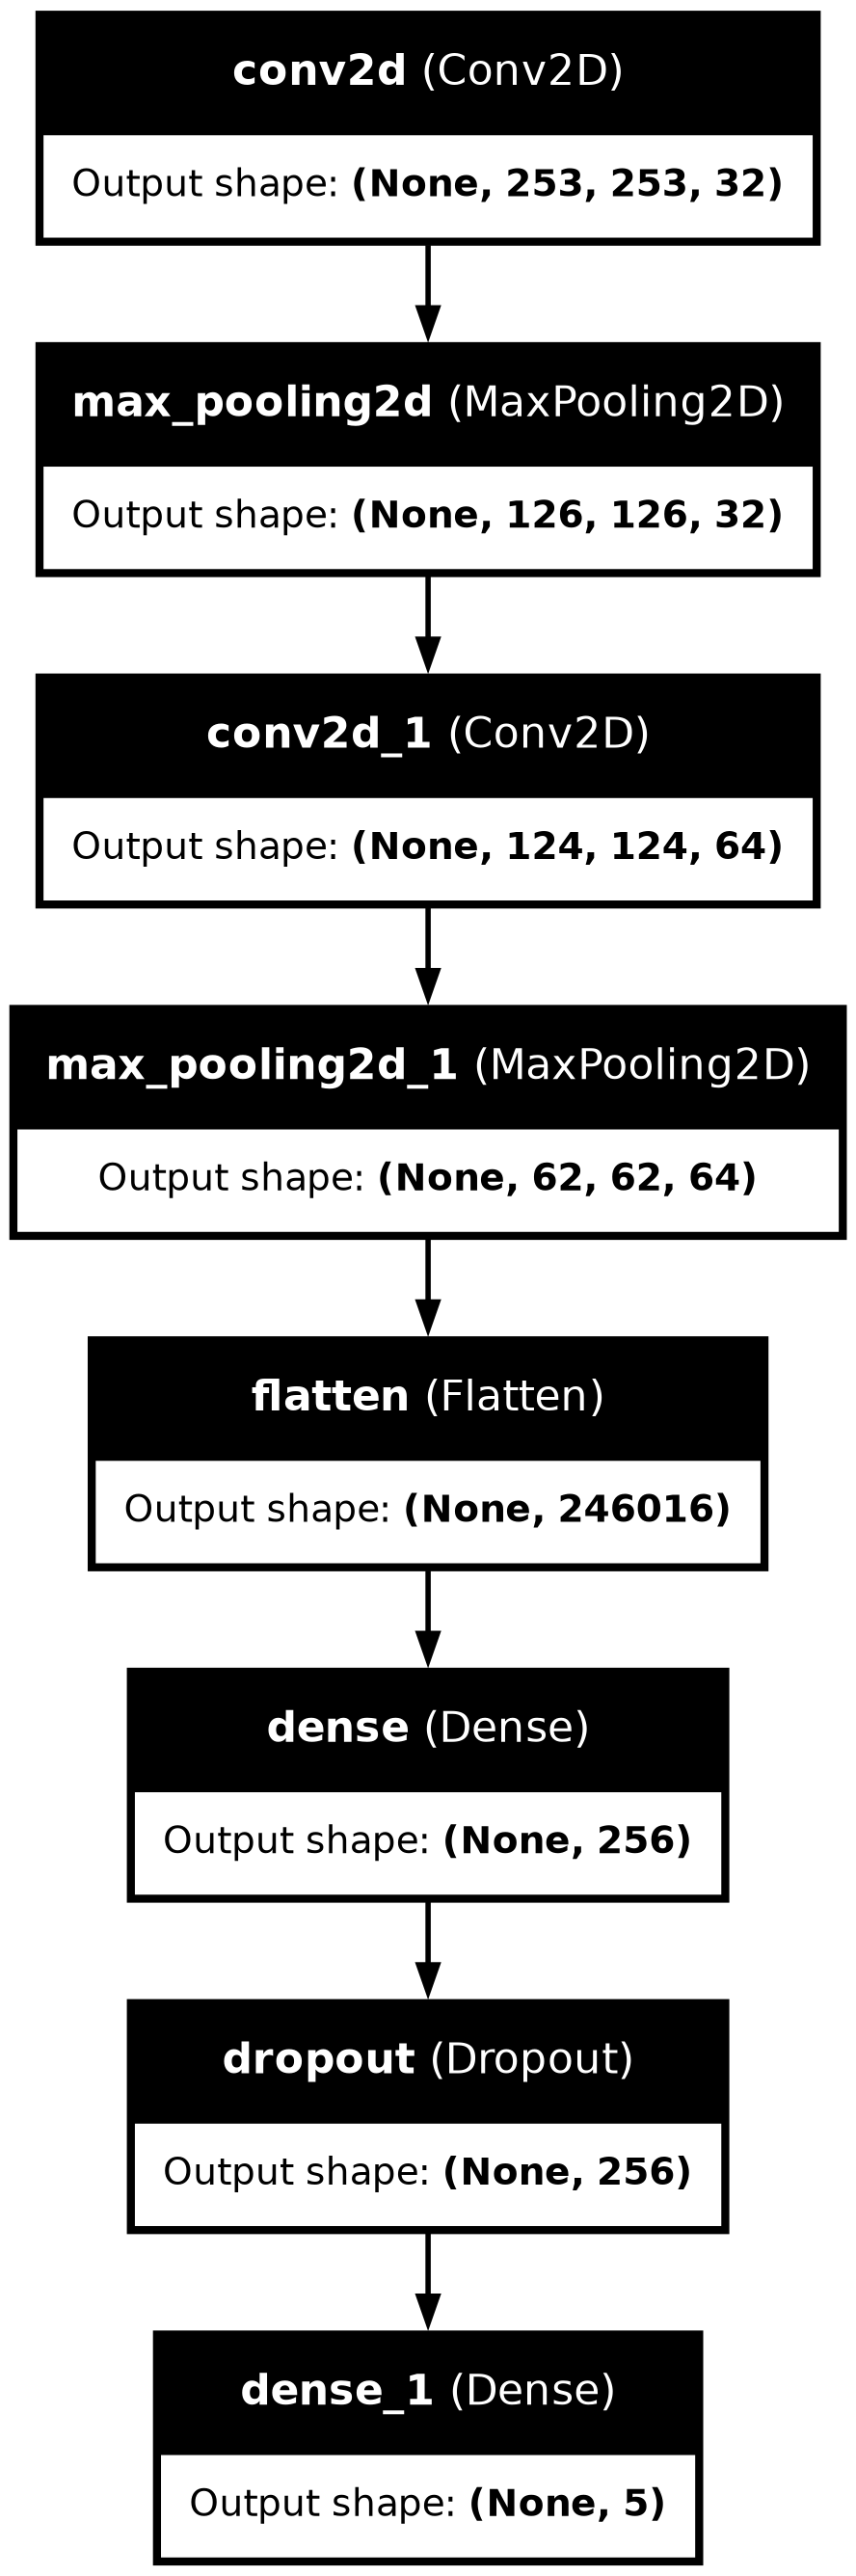

In [30]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [31]:
import tensorflow as tf
with tf.device('/GPU:0'):
    h3 = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-06 17:53:43.105042: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.51807, expected 5.71706
2024-05-06 17:53:43.105101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.83357, expected 5.03256
2024-05-06 17:53:43.105117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.58305, expected 5.78204
2024-05-06 17:53:43.105133: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.85281, expected 6.0518
2024-05-06 17:53:43.105146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

 3/65 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2170 - loss: 171.9899

I0000 00:00:1715018029.488053      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/65 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1988 - loss: 245.9120

2024-05-06 17:53:51.263361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64010: 6.21491, expected 5.3506
2024-05-06 17:53:51.263420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64011: 5.92152, expected 5.05722
2024-05-06 17:53:51.263436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64012: 5.43752, expected 4.57322
2024-05-06 17:53:51.263454: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64013: 6.40103, expected 5.53672
2024-05-06 17:53:51.263468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64014: 6.62565, expected 5.76134
2024-05-06 17:53:51.263480: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64015: 6.83154, expected 5.96724
2024-05-06 17:53:51.263492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64016: 5.9599, expected 5.09559
2024-05-06 17:53:51.263503: E

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2028 - loss: 124.8152

2024-05-06 17:54:00.227007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128155: 4.59109, expected 4.02699
2024-05-06 17:54:00.227087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128384: 4.58902, expected 4.02492
2024-05-06 17:54:00.227101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128409: 4.56257, expected 3.99847
2024-05-06 17:54:00.227117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128429: 4.55163, expected 3.98753
2024-05-06 17:54:00.227136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128431: 4.5635, expected 3.9994
2024-05-06 17:54:00.227151: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128472: 4.34488, expected 3.78077
2024-05-06 17:54:00.227162: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128473: 4.46631, expected 3.9022
2024-05-06 17:54:00.227

65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.2025 - loss: 122.4797 - val_accuracy: 0.1818 - val_loss: 1.6144
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2177 - loss: 1.6297 - val_accuracy: 0.2727 - val_loss: 1.6069
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2681 - loss: 1.6620 - val_accuracy: 0.2727 - val_loss: 1.6067
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2773 - loss: 1.6047 - val_accuracy: 0.2727 - val_loss: 1.6054
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2483 - loss: 1.6054 - val_accuracy: 0.2727 - val_loss: 1.6033
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2534 - loss: 1.6039 - val_accuracy: 0.2727 - val_loss: 1.6038
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.2515 - loss: 1.6029 - val_accuracy: 0.2727 - val_loss: 1.6004
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.2436 - loss: 1.6043 - val_accuracy: 0.2727 - val_loss

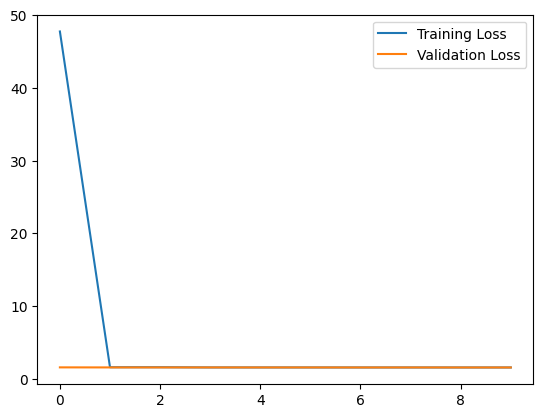

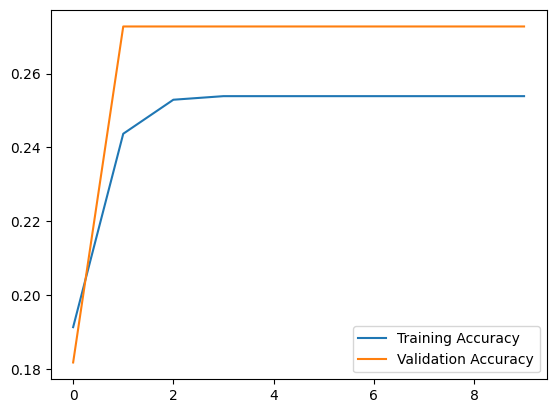

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(h3.history['loss'], label='Training Loss')
plt.plot(h3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(h3.history['accuracy'], label='Training Accuracy')
plt.plot(h3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [33]:
import shutil
shutil.rmtree("/kaggle/working/scaleogram")
# shutil.rmtree("/kaggle/tmp")